In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [58]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

In [134]:
year = '11'
model = 'model_old_v6'
soft_normalization = True # default: True
sys_err = False

In [135]:
data = pd.read_csv(f'../outputs/{year}/tables/signal_table{year}{"_sys" if sys_err else ""}.csv', index_col='name')
triggers = pd.read_csv(f'../outputs/{year}/tables/triggers{year}{"_sys" if sys_err else ""}.csv', index_col='name')
reg_eff = pd.read_csv(f'../outputs/{model}/tables/signal_table{model}{"_sys" if sys_err else ""}.csv', 
                      index_col='name')

In [136]:
data

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
525.0,469.339,0.00,0.00,523.58,804.7929,29.1049
537.5,554.231,0.00,0.00,537.41,910.6881,30.6632
550.0,493.501,0.00,0.00,548.44,387.7093,20.2310
562.5,549.094,0.00,0.00,562.13,399.0236,20.5402
575.0,493.710,0.00,0.00,575.31,180.6345,13.8589
587.5,522.721,0.00,0.00,587.05,179.9851,14.1245
600.0,557.452,0.00,0.00,598.04,100.0116,10.0009
612.5,536.375,0.00,0.00,611.71,127.8495,11.7114
625.0,411.009,0.00,0.00,622.47,45.5837,6.8436


Triggers

In [137]:
triggers.tail()

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
850.0,8.0,0.0,20.0,0.9545,0.7000,0.9864,0.0434,0.0823,0.0136
862.5,13.0,1.0,13.0,0.8750,0.5000,0.9375,0.0802,0.0928,0.0418
875.0,11.0,0.0,7.0,0.8889,0.4000,0.9333,0.0994,0.1069,0.0608
910.0,14.0,1.0,15.0,0.8889,0.5161,0.9462,0.0721,0.0883,0.0362
950.0,16.0,1.0,7.0,0.8000,0.3200,0.8640,0.1206,0.0915,0.0840


In [138]:
reg_eff.head()

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
550.0,7163,0.0,0.0,550.0,1775.3351,43.7841
562.5,6306,0.0,0.0,562.5,1562.3131,41.0725
575.0,5516,0.0,0.0,575.0,1372.7035,38.4817
587.5,5116,0.0,0.0,587.5,1293.5363,37.2771
600.0,4606,0.0,0.0,600.0,1152.9720,35.5311


Get N/L

In [139]:
data['CSvis'] = data['Nsig']/data['lum']
data['dCSvis'] = data['dNsig']/data['lum']

In [140]:
data.shape

(31, 8)

Trigger join

In [141]:
data = data.join(triggers[['TrigEff', 'TrigErr']], how='left')

In [142]:
data.shape #сверить с предыдущим shape

(31, 10)

In [143]:
data = data.drop(['Nsig', 'dNsig', 'lum'], axis=1)

Get Reg_eff

In [144]:
reg_eff['RegEff'] = reg_eff['Nsig']/  (reg_eff['lum'] if soft_normalization else 20000)
reg_eff['RegErr'] = reg_eff['dNsig']/ (reg_eff['lum'] if soft_normalization else 20000)
reg_eff.drop(['dEmax', 'dEmin', 'lum', 'Nsig', 'dNsig'], axis=1, inplace=True)

Reg eff join

In [145]:
data['RegEff'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegEff), axis=1)
data['RegErr'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegErr), axis=1)

Recalc cross section

In [146]:
data['CS'] = data['CSvis']/data['TrigEff']/data['RegEff'];
data['dCS'] = data['CS']*np.sqrt( np.square( data['dCSvis']/data['CSvis'] ) + 
                                np.square( data['TrigErr']/data['TrigEff'] ) + 
                                np.square( data['RegErr']/data['RegEff'] ))

In [147]:
#data.drop(['CSvis', 'dCSvis', 'TrigEff', 'TrigErr', 'RegEff', 'RegErr'], axis=1, inplace=True)

In [148]:
norm = 'soft' if soft_normalization else 'all'
data.to_csv(f'../outputs/cross_sections/vis_{year}_{model}_{norm}{"_sys" if sys_err else ""}.csv', float_format='%.5f')

## Draw cross sections

In [149]:
cs = dict()

In [150]:
cs['11_old'] = pd.read_csv('../outputs/cross_sections/vis_11_model_old_v6_all.csv', index_col=['name'])
cs['11_new'] = pd.read_csv('../outputs/cross_sections/vis_11_model_new_v6_all.csv', index_col=['name'])
# cs11 = pd.read_csv('../outputs/11/tables/result_visible.csv', index_col=['name'])
# cs12 = pd.read_csv('../outputs/12/tables/result_visible.csv', index_col=['name'])
# cs17 = pd.read_csv('../outputs/17/tables/result_visible.csv', index_col=['name'])
# cs19 = pd.read_csv('../outputs/19/tables/result_visible.csv', index_col=['name'])

In [151]:
#radcor = pd.read_csv('rad_cors.dat', delimiter='\t', names=['energy', 'radcor'], index_col=['energy'])
radcor = pd.read_csv('../outputs/radcors.dat', names=['energy', 'radcor'], index_col=['energy'])
radcor.index *= 0.5e3
radcor = radcor.sort_index()

In [152]:
cs['11_new'].tail()

,dEmin,dEmax,Emean,CSvis,dCSvis,TrigEff,TrigErr,RegEff,RegErr,CS,dCS
name,,,,,,,,,,,
850.0,0.00,0.00,846.43,0.05057,0.01043,0.9864,0.0136,0.07687,0.00207,0.66697,0.13905
862.5,0.00,0.00,861.56,0.03634,0.00950,0.9375,0.0418,0.05055,0.00166,0.76689,0.20487
875.0,0.00,0.00,870.82,0.03069,0.00764,0.9333,0.0608,0.03701,0.00142,0.88854,0.23118
910.0,25.42,23.31,912.28,0.00758,0.00188,0.9462,0.0362,0.01013,0.00077,0.79121,0.20689
950.0,24.05,31.56,970.75,0.00311,0.00129,0.8640,0.0840,0.01096,0.00077,0.32801,0.14166


In [153]:
# plt.scatter(radcor.index, radcor.radcor)

In [154]:
radcor.head()

,radcor
energy,
523.58,0.860423
537.41,0.857320
537.45,0.858782
548.44,0.863543
549.34,0.863995


In [155]:
for k in cs:
    cs[k]['rad'] = np.interp(cs[k].Emean, radcor.index, radcor.radcor)

In [156]:
def born(data):
    data['born'] = data.CS/data.rad
    data['born_err'] = data.dCS/data.rad

In [157]:
for k in cs:
    born(cs[k])

In [158]:
errE = dict()
for k in cs:
    errE[k] = [cs[k].dEmin*2e-3, cs[k].dEmax*2e-3]

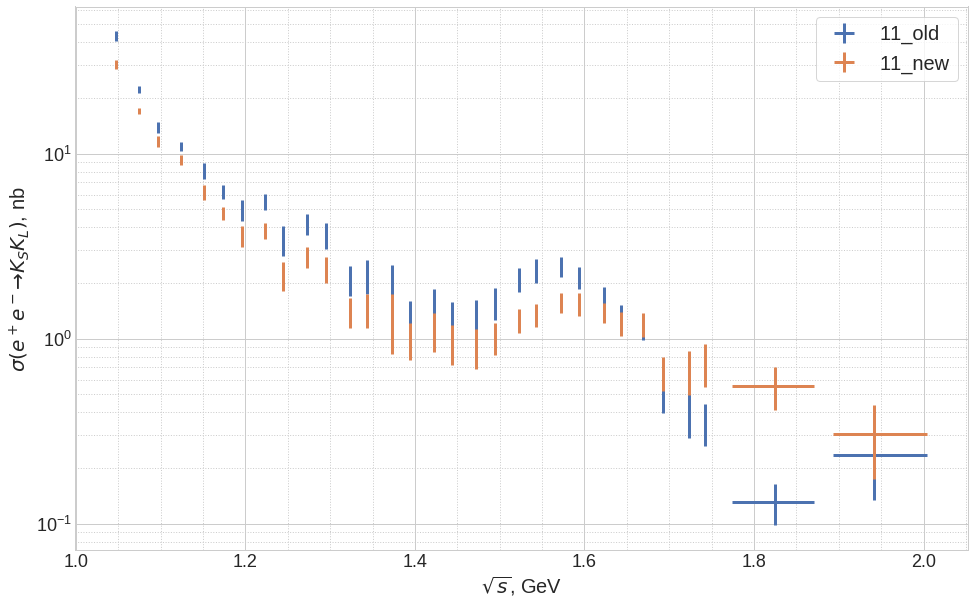

In [159]:
for k in cs:
    plt.errorbar(cs[k].Emean*2e-3, cs[k].born, yerr=cs[k].born_err, xerr=errE[k], fmt='o',
                elinewidth=3, ms=0, label=k)

# plt.errorbar(cs11.Emean*2e-3, cs11.born, yerr=cs11.born_err, xerr=errE[11], fmt='ro', elinewidth=3, ms=0, label='2011')
# plt.errorbar(cs12.Emean*2e-3, cs12.born, yerr=cs12.born_err, xerr=errE[12], fmt='bo', elinewidth=3, ms=0, label='2012')
# plt.errorbar(cs17.Emean*2e-3, cs17.born, yerr=cs17.born_err, xerr=errE[17], fmt='go', elinewidth=3, ms=0, label='2017')
# plt.errorbar(cs19.Emean*2e-3, cs19.born, yerr=cs19.born_err, xerr=errE[19], fmt='ko', elinewidth=3, ms=0, label='2019')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma(e^+e^- \\to K_SK_L)$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18);
ax.legend(fontsize=20, frameon=True);

plt.grid(linestyle = '-');
ax = plt.gca();
ax.minorticks_on();
ax.grid(which='minor', linestyle = ':');

plt.savefig('cs.pdf')

### Некоторые проверки

1. Проверить `RegEff`
2. Проверить видимое сечение
3. Проверить триггеры

<ErrorbarContainer object of 3 artists>

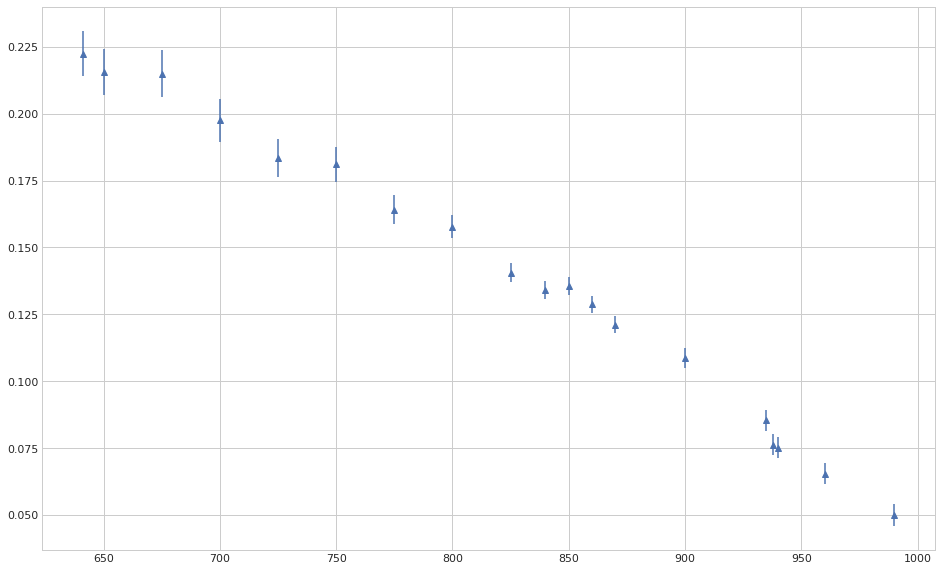

In [109]:
plt.errorbar(data=cs17, x=cs17.index, y='RegEff', yerr='RegErr', fmt='^')

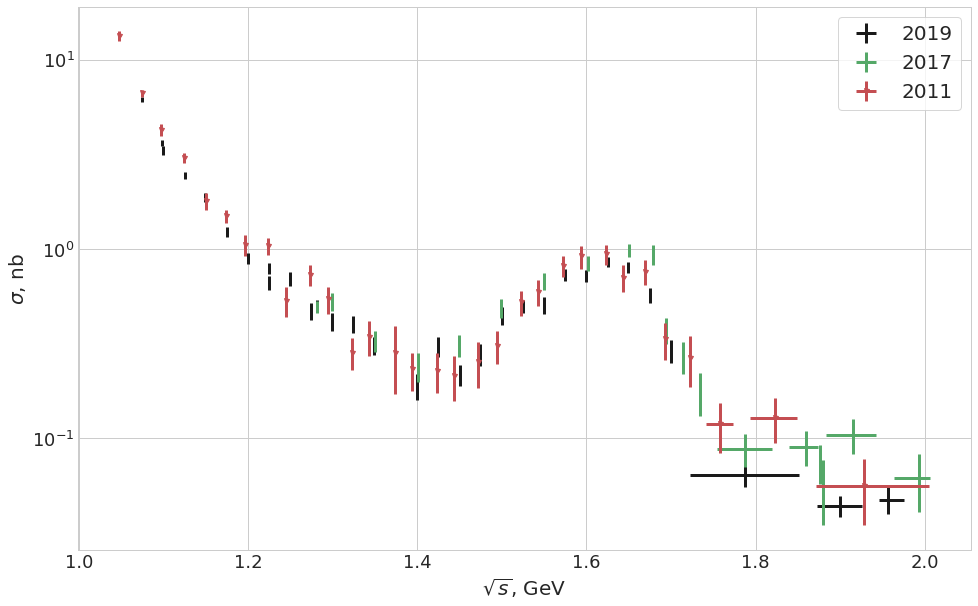

In [144]:
plt.errorbar(cs19.Emean*2e-3, cs19.CS, yerr=cs19.dCS, xerr=errE[19], fmt='kd', elinewidth=3, ms=0, label='2019')
plt.errorbar(cs17.Emean*2e-3, cs17.CS, yerr=cs17.dCS, xerr=errE[17], fmt='g^', elinewidth=3, ms=0, label='2017')
# plt.errorbar(cs12.Emean*2e-3, cs12.CS, yerr=cs12.dCS, xerr=errE[12], fmt='bp', elinewidth=3, ms=5, label='2012')
plt.errorbar(cs11.Emean*2e-3, cs11.CS, yerr=cs11.dCS, xerr=errE[11], fmt='rv', elinewidth=3, ms=5, label='2011')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18)
ax.legend(fontsize=20, frameon=True)


In [28]:
cs11

,dEmin,dEmax,Emean,CSvis,dCSvis,TrigEff,TrigErr,RegEff,RegErr,CS,dCS,rad,born,born_err
name,,,,,,,,,,,,,,
525.0,0.00,0.00,523.58,1.69314,0.06183,0.5197,0.0202,0.23985,0.00599,13.58314,0.79986,0.856548,15.858002,0.933818
537.5,0.00,0.00,537.41,1.59773,0.05462,0.9714,0.0061,0.23985,0.00599,6.85748,0.29345,0.855641,8.014440,0.342959
550.0,0.00,0.00,548.44,0.77005,0.04053,0.7381,0.0276,0.23985,0.00599,4.34974,0.30108,0.861648,5.048164,0.349423
562.5,0.00,0.00,562.13,0.70477,0.03690,0.9679,0.0099,0.23755,0.00637,3.06522,0.18302,0.870443,3.521450,0.210261
575.0,0.00,0.00,575.31,0.32007,0.02631,0.7425,0.0408,0.23815,0.00681,1.81006,0.18630,0.877349,2.063100,0.212344
587.5,0.00,0.00,587.05,0.33431,0.02671,0.9644,0.0155,0.23984,0.00706,1.44532,0.12522,0.884638,1.633799,0.141549
600.0,0.00,0.00,598.04,0.17402,0.01767,0.7007,0.0498,0.23206,0.00735,1.07025,0.13691,0.889378,1.203370,0.153939
612.5,0.00,0.00,611.71,0.22268,0.02122,0.9492,0.0218,0.22564,0.00787,1.03970,0.10815,0.894639,1.162145,0.120887
625.0,0.00,0.00,622.47,0.10153,0.01603,0.8519,0.0656,0.21242,0.00777,0.56108,0.10069,0.897899,0.624881,0.112140


<ErrorbarContainer object of 3 artists>

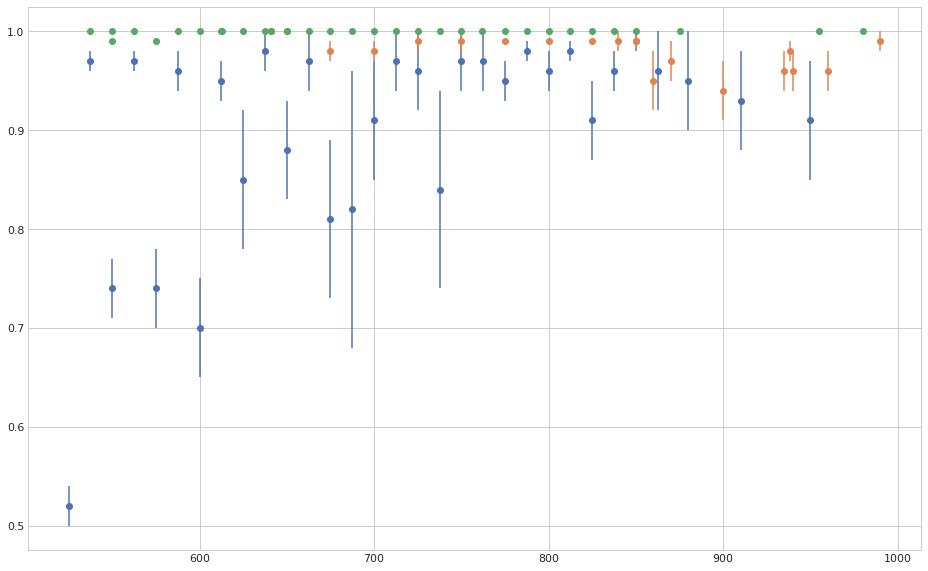

In [143]:
plt.errorbar(data=cs11, x=cs11.index, y='TrigEff', yerr='TrigErr', fmt='o')
plt.errorbar(data=cs17, x=cs17.index, y='TrigEff', yerr='TrigErr', fmt='o')
plt.errorbar(data=cs19, x=cs19.index, y='TrigEff', yerr='TrigErr', fmt='o')